In [254]:
from qubitPack.tool_box import get_db
import pandas as pd

In [415]:
from pymatgen.io.vasp.inputs import Structure
import numpy as np

def get_st(st, bottom=24, NN=None):
    data = []
    for st in [st]:
        if not NN:
            NN = e["NN"]
        print(np.round(np.array(st.lattice.abc)/5, 4).tolist())
        print(np.around(np.array([st.get_distance(NN[-1], x) for x in NN+[bottom] ]), 4))
        d = dict(
            zip(
                ["d1", "d2", "d3", "d4", "z1", "z2", "z3", "z4", "a", "b", "c"],
                np.around(
                    np.array(
                        [st.get_distance(NN[-1], x) for x in NN[:-1]+[bottom] ]+
                        [st.sites[NN[-1]].coords[-1] - st.sites[x].coords[-1] for x in NN[:-1]+[bottom]]+
                        np.round(np.array(st.lattice.abc)/5, 4).tolist()
                    ), 3
                )
            )
        )
        data.append(d)
    import  pandas as pd
    return data

In [282]:
def get_zpl_soc(d, soc_taskid):
    B = d["task_label"].str.contains("B-")
    C = d["task_label"].str.contains("C-")
    D = d["task_label"].str.contains("D-")
    
    d = d.loc[d["soc_taskid"] == soc_taskid, :]
    occs = d.loc[:, "occ"].unique()
    
    results = []
    for occ in occs:
        zpl = {}
        dd = d.loc[d["occ"] == occ, :]
        display(dd)
        chem = {"chemsys": dd.loc[B, "chemsys"].values[0]}
        occ = {"occ": dd.loc[B, "occ"].values[0]}
        PS = {"PS": dd.loc[B, "PS"].values[0]}
        
        try:
            A_B = {"A-B": dd.loc[B, "final_energy"].values[0] - dd.loc[B, "soc_energy"].values[0]}
            B_C = {"B-C": dd.loc[B, "final_energy"].values[0] - dd.loc[C, "final_energy"].values[0]}
            C_D = {"C-D": dd.loc[C, "final_energy"].values[0] - dd.loc[D, "final_energy"].values[0]}
            D_A = {"D-A": dd.loc[D, "final_energy"].values[0] - dd.loc[D, "soc_energy"].values[0]}
            ZPL = {"ZPL": dd.loc[C, "final_energy"].values[0] - dd.loc[C, "soc_energy"].values[0]}
        except Exception as er:
            print(er)
            continue
            
        for i in [chem, occ, PS, A_B, B_C, C_D, D_A, ZPL]:
            zpl.update(i)
        results.append(zpl)
    return results

In [283]:
def get_zpl_std(d, std_taskid):
    B = d["task_label"].str.contains("B-")
    C = d["task_label"].str.contains("C-")
    D = d["task_label"].str.contains("D-")
    
    d = d.loc[d["std_taskid"] == std_taskid, :]
    d = d.loc[d["PS"] == "0.5-0.5-1"]
    occs = d.loc[:, "occ"].unique()
    
    results = []
    for occ in occs:
        try:
            zpl = {}
            dd = d.loc[d["occ"] == occ, :]
            display(dd)
            chem = {"chemsys": dd.loc[B, "chemsys"].values[0]}
            occ = {"occ": dd.loc[B, "occ"].values[0]}
            PS = {"PS": dd.loc[B, "PS"].values[0]}
        
            A_B = {"A-B": dd.loc[B, "final_energy"].values[0] - dd.loc[B, "std_energy"].values[0]}
            B_C = {"B-C": dd.loc[B, "final_energy"].values[0] - dd.loc[C, "final_energy"].values[0]}
            C_D = {"C-D": dd.loc[C, "final_energy"].values[0] - dd.loc[D, "final_energy"].values[0]}
            D_A = {"D-A": dd.loc[D, "final_energy"].values[0] - dd.loc[D, "std_energy"].values[0]}
            ZPL = {"ZPL": dd.loc[C, "final_energy"].values[0] - dd.loc[C, "std_energy"].values[0]}
        except Exception as er:
            print(er)
            continue


        for i in [chem, occ, PS, A_B, B_C, C_D, D_A, ZPL]:
            zpl.update(i)
        results.append(zpl)
    return results

# The latest calculations of singlets and triplets

## soc

In [229]:
db = get_db("single_photon_emitter", "soc_standard_defect")

In [230]:
singlets = db.collection.find({"nupdown_set":0, "prev_fw_taskid": {"$exists":1}})

In [231]:
data = []
for e in singlets:
    singlet_energy = e["output"]["energy"]
    row = {
        "task_id": e["task_id"],
        "chemsys": e["chemsys"], 
        "final_energy": e["output"]["energy"],
        "nosoc_taskid": e["prev_fw_taskid"]
    }
    data.append(row)

In [232]:
singlet_data = pd.DataFrame(data)
singlet_data

,task_id,chemsys,final_energy,nosoc_taskid
0,695,Se-W,-671.231456,690
1,705,S-W,-727.165968,699
2,706,Mo-S,-661.429131,700
3,707,Mo-Se,-609.567691,702
4,716,Te-W,-615.755389,715
5,742,Mo-Te,-558.895949,721
6,803,Te-W,-616.715970,800
7,813,Te-W,-616.717853,808
8,814,S-W,-727.172609,811


In [245]:
triplets = db.collection.find({"nupdown_set":2, "prev_fw_taskid": {"$exists":1}})

In [246]:
data = []
for e in triplets:
    triplet_energy = e["output"]["energy"]
    row = {
        "task_id": e["task_id"], 
        "chemsys": e["chemsys"], 
        "final_energy": e["output"]["energy"],
        "nosoc_taskid": e["prev_fw_taskid"]
    }
    data.append(row)

In [247]:
triplet_data = pd.DataFrame(data)
triplet_data
display(triplet_data)
display(triplet_data.loc[triplet_data["chemsys"].isin(["Te-W", "Mo-Te"]), :])

,task_id,chemsys,final_energy,nosoc_taskid
0,617,Se-W,-671.422814,616
1,633,Mo-Se,-609.879379,632
2,637,Te-W,-616.106836,636
3,645,S-W,-727.316748,640
4,646,Mo-S,-661.742511,643
5,647,Se-W,-671.422822,642
6,655,Se-W,-671.422547,652
7,659,Mo-Te,-559.151629,653
8,697,Se-W,-671.422198,692
9,794,Te-W,-616.312748,792


,task_id,chemsys,final_energy,nosoc_taskid
2,637,Te-W,-616.106836,636
7,659,Mo-Te,-559.151629,653
9,794,Te-W,-616.312748,792
10,798,Mo-Te,-559.338274,797
11,810,Te-W,-616.312681,807
13,822,Te-W,-616.107891,819
14,823,Mo-Te,-559.152064,821


In [236]:
soc = triplet_data.merge(singlet_data, on=["chemsys"])
display(soc.loc[soc["chemsys"] == "S-W", :])
soc["diff"] = soc["final_energy_x"] - soc["final_energy_y"]
display(soc.round(3))
display(soc.loc[soc["task_id_x"].isin([645, 647, 646, 633, 812]), :].round(3))

,task_id_x,chemsys,final_energy_x,nosoc_taskid_x,task_id_y,final_energy_y,nosoc_taskid_y
17,645,S-W,-727.316748,640,705,-727.165968,699
18,645,S-W,-727.316748,640,814,-727.172609,811
19,812,S-W,-727.379860,809,705,-727.165968,699
20,812,S-W,-727.379860,809,814,-727.172609,811


,task_id_x,chemsys,final_energy_x,nosoc_taskid_x,task_id_y,final_energy_y,nosoc_taskid_y,diff
0,617,Se-W,-671.423,616,695,-671.231,690,-0.191
1,647,Se-W,-671.423,642,695,-671.231,690,-0.191
2,655,Se-W,-671.423,652,695,-671.231,690,-0.191
3,697,Se-W,-671.422,692,695,-671.231,690,-0.191
4,633,Mo-Se,-609.879,632,707,-609.568,702,-0.312
5,637,Te-W,-616.107,636,716,-615.755,715,-0.351
6,637,Te-W,-616.107,636,803,-616.716,800,0.609
7,637,Te-W,-616.107,636,813,-616.718,808,0.611
8,794,Te-W,-616.313,792,716,-615.755,715,-0.557
9,794,Te-W,-616.313,792,803,-616.716,800,0.403


,task_id_x,chemsys,final_energy_x,nosoc_taskid_x,task_id_y,final_energy_y,nosoc_taskid_y,diff
1,647,Se-W,-671.423,642,695,-671.231,690,-0.191
4,633,Mo-Se,-609.879,632,707,-609.568,702,-0.312
17,645,S-W,-727.317,640,705,-727.166,699,-0.151
18,645,S-W,-727.317,640,814,-727.173,811,-0.144
19,812,S-W,-727.380,809,705,-727.166,699,-0.214
20,812,S-W,-727.380,809,814,-727.173,811,-0.207
21,646,Mo-S,-661.743,643,706,-661.429,700,-0.313


## nosoc

In [421]:
nosoc_db = get_db("single_photon_emitter", "standard_defect")

In [422]:
nosoc_singlets = nosoc_db.collection.find({"task_id": {"$in": soc.loc[:, "nosoc_taskid_x"].tolist()}})
nosoc_triplets = nosoc_db.collection.find({"task_id": {"$in": soc.loc[:, "nosoc_taskid_y"].tolist()}})

In [423]:
nosoc_singlet_data = []
for e in nosoc_singlets:
    singlet_energy = e["output"]["energy"]
    row = {"task_id": e["task_id"], "chemsys": e["chemsys"], "final_energy": e["output"]["energy"]}
    nosoc_singlet_data.append(row)
nosoc_singlet_data = pd.DataFrame(nosoc_singlet_data)

nosoc_triplet_data = []
for e in nosoc_triplets:
    triplet_energy = e["output"]["energy"]
    row = {"task_id": e["task_id"], "chemsys": e["chemsys"], "final_energy": e["output"]["energy"]}
    nosoc_triplet_data.append(row)
nosoc_triplet_data = pd.DataFrame(nosoc_triplet_data)

In [424]:
nosoc = nosoc_singlet_data.merge(nosoc_triplet_data, on="chemsys")
nosoc["diff"] = nosoc["final_energy_x"] - nosoc["final_energy_y"]
display(nosoc.loc[nosoc["chemsys"].isin(["Te-W", "Mo-Te"])].round(3))
display(nosoc.loc[nosoc["task_id_x"].isin([640, 642, 643, 632, 636, 653]), :].round(3))

,task_id_x,chemsys,final_energy_x,task_id_y,final_energy_y,diff
5,636,Te-W,-590.895,715,-590.594,-0.301
6,636,Te-W,-590.895,800,-590.908,0.013
7,636,Te-W,-590.895,808,-590.907,0.012
8,792,Te-W,-591.150,715,-590.594,-0.556
9,792,Te-W,-591.150,800,-590.908,-0.242
10,792,Te-W,-591.150,808,-590.907,-0.244
11,807,Te-W,-591.150,715,-590.594,-0.556
12,807,Te-W,-591.150,800,-590.908,-0.242
13,807,Te-W,-591.150,808,-590.907,-0.243
14,819,Te-W,-590.895,715,-590.594,-0.301


,task_id_x,chemsys,final_energy_x,task_id_y,final_energy_y,diff
1,642,Se-W,-650.612,690,-650.316,-0.295
4,632,Mo-Se,-606.360,702,-606.017,-0.343
5,636,Te-W,-590.895,715,-590.594,-0.301
6,636,Te-W,-590.895,800,-590.908,0.013
7,636,Te-W,-590.895,808,-590.907,0.012
17,640,S-W,-707.949,699,-707.676,-0.273
18,640,S-W,-707.949,811,-707.687,-0.262
21,643,Mo-S,-659.173,700,-658.824,-0.349
22,653,Mo-Te,-551.906,721,-551.642,-0.264


In [418]:
db = get_db("single_photon_emitter", "soc_standard_defect")
es = db.collection.find({"task_id": {"$in": soc.loc[:, "task_id_x"].unique().tolist()}})
st_infos = []
for e in es:
    st = Structure.from_dict(e["output"]["structure"])
    st_info = get_st(st)
    st_info[0].update({"soc_taskid": e["task_id"], "chemsys": e["chemsys"], "nosoc_taskid": e["prev_fw_taskid"],
                       "E": e["output"]["energy"]
                      })
    st_infos.extend(st_info)

g = pd.DataFrame(st_infos)
g = g.loc[:, ["d1", "d2", "d3", "z1", "z4", "a", "soc_taskid", "chemsys", "nosoc_taskid", "E"]]
g.sort_values("z1", inplace=True)
display(g.loc[g["chemsys"].isin(["Te-W", "Mo-Te"]), :])
display(g.loc[g["soc_taskid"].isin([645, 647, 646, 633, 812]), :])

[3.2755, 3.2755, 4.6622]
[2.6151 2.6151 2.6151 0.     5.2891]
[3.2782, 3.2782, 4.6599]
[2.6554 2.6553 2.6553 0.     5.3026]
[3.5046, 3.5046, 4.7156]
[2.5782 2.5782 2.5782 0.     2.9156]
[3.1474, 3.1474, 4.6213]
[2.6327 2.6327 2.6327 0.     5.1305]
[3.1469, 3.1469, 4.6181]
[2.6691 2.6691 2.6691 0.     5.1384]
[3.2755, 3.2755, 4.6622]
[2.6148 2.6148 2.6148 0.     5.289 ]
[3.2755, 3.2755, 4.6622]
[2.6152 2.6152 2.6152 0.     5.2901]
[3.5052, 3.5052, 4.7147]
[2.5789 2.5789 2.5789 0.     3.0648]
[3.2755, 3.2755, 4.6622]
[2.6148 2.6148 2.6148 0.     5.2897]
[3.5046, 3.5046, 4.7156]
[2.4972 2.6977 2.4973 0.     2.9655]
[3.5052, 3.5052, 4.7147]
[2.4632 2.7725 2.4631 0.     2.9712]
[3.5046, 3.5046, 4.7156]
[2.4973 2.497  2.6987 0.     2.9658]
[3.1474, 3.1474, 4.6213]
[2.5371 2.7018 2.6885 0.     5.1787]
[3.5046, 3.5046, 4.7156]
[2.5788 2.5788 2.5788 0.     2.9157]
[3.5052, 3.5052, 4.7147]
[2.5798 2.5798 2.5798 0.     3.0675]


,d1,d2,d3,z1,z4,a,soc_taskid,chemsys,nosoc_taskid,E
2,2.578,2.578,2.578,1.302,2.916,3.505,637,Te-W,636,-616.106836
13,2.579,2.579,2.579,1.302,2.916,3.505,822,Te-W,819,-616.107891
10,2.463,2.772,2.463,1.337,2.932,3.505,798,Mo-Te,797,-559.338274
9,2.497,2.698,2.497,1.342,2.933,3.505,794,Te-W,792,-616.312748
11,2.497,2.497,2.699,1.343,2.933,3.505,810,Te-W,807,-616.312681
7,2.579,2.579,2.579,1.409,3.065,3.505,659,Mo-Te,653,-559.151629
14,2.580,2.580,2.580,1.413,3.067,3.505,823,Mo-Te,821,-559.152064


,d1,d2,d3,z1,z4,a,soc_taskid,chemsys,nosoc_taskid,E
5,2.615,2.615,2.615,1.868,1.766,3.276,647,Se-W,642,-671.422822
1,2.655,2.655,2.655,1.926,1.806,3.278,633,Mo-Se,632,-609.879379
3,2.633,2.633,2.633,1.932,1.826,3.147,645,S-W,640,-727.316748
4,2.669,2.669,2.669,1.985,1.858,3.147,646,Mo-S,643,-661.742511
12,2.537,2.702,2.689,1.992,1.827,3.147,812,S-W,809,-727.379860


In [410]:
db = get_db("single_photon_emitter", "standard_defect")
es = db.collection.find({"task_id": {"$in": g.loc[:, "nosoc_taskid"].unique().tolist()}})
st_infos = []
for e in es:
    st = Structure.from_dict(e["output"]["structure"])
    st_info = get_st(st)
    st_info[0].update({"nosoc_taskid": e["task_id"], "chemsys": e["chemsys"], "E": e["output"]["energy"]
                      })
    st_infos.extend(st_info)

g = pd.DataFrame(st_infos)
g = g.loc[:, ["d1", "d2", "d3", "z1", "z4", "a", "chemsys", "nosoc_taskid", "E"]]
g.sort_values("z1", inplace=True)
display(g)
display(g.loc[g["nosoc_taskid"].isin([636, 653]), :])

[3.2755, 3.2755, 4.6622]
[2.6151 2.6151 2.6151 0.     5.2891]
[3.2782, 3.2782, 4.6599]
[2.6554 2.6553 2.6553 0.     5.3026]
[3.5046, 3.5046, 4.7156]
[2.5782 2.5782 2.5782 0.     2.9156]
[3.1474, 3.1474, 4.6213]
[2.6327 2.6327 2.6327 0.     5.1305]
[3.2755, 3.2755, 4.6622]
[2.6148 2.6148 2.6148 0.     5.289 ]
[3.1469, 3.1469, 4.6181]
[2.6691 2.6691 2.6691 0.     5.1384]
[3.2755, 3.2755, 4.6622]
[2.6152 2.6152 2.6152 0.     5.2901]
[3.5052, 3.5052, 4.7147]
[2.5789 2.5789 2.5789 0.     3.0648]
[3.2755, 3.2755, 4.6622]
[2.6148 2.6148 2.6148 0.     5.2897]
[3.5046, 3.5046, 4.7156]
[2.4972 2.6977 2.4973 0.     2.9655]
[3.5052, 3.5052, 4.7147]
[2.4632 2.7725 2.4631 0.     2.9712]
[3.5046, 3.5046, 4.7156]
[2.4973 2.497  2.6987 0.     2.9658]
[3.1474, 3.1474, 4.6213]
[2.5371 2.7018 2.6885 0.     5.1787]
[3.5046, 3.5046, 4.7156]
[2.5788 2.5788 2.5788 0.     2.9157]
[3.5052, 3.5052, 4.7147]
[2.5798 2.5798 2.5798 0.     3.0675]


,d1,d2,d3,z1,z4,a,chemsys,nosoc_taskid,E
2,2.578,2.578,2.578,1.302,2.916,3.505,Te-W,636,-590.894956
13,2.579,2.579,2.579,1.302,2.916,3.505,Te-W,819,-590.894944
10,2.463,2.772,2.463,1.337,2.932,3.505,Mo-Te,797,-552.089498
9,2.497,2.698,2.497,1.342,2.933,3.505,Te-W,792,-591.150464
11,2.497,2.497,2.699,1.343,2.933,3.505,Te-W,807,-591.150355
7,2.579,2.579,2.579,1.409,3.065,3.505,Mo-Te,653,-551.906297
14,2.580,2.580,2.580,1.413,3.067,3.505,Mo-Te,821,-551.906829
8,2.615,2.615,2.615,1.867,1.769,3.276,Se-W,692,-650.610985
0,2.615,2.615,2.615,1.868,1.766,3.276,Se-W,616,-650.611583
4,2.615,2.615,2.615,1.868,1.766,3.276,Se-W,642,-650.611609


,d1,d2,d3,z1,z4,a,chemsys,nosoc_taskid,E
2,2.578,2.578,2.578,1.302,2.916,3.505,Te-W,636,-590.894956
7,2.579,2.579,2.579,1.409,3.065,3.505,Mo-Te,653,-551.906297


# SOC cdft 

In [403]:
soc_cdft = get_db("single_photon_emitter", "soc_cdft")
soc_cdft_data = soc_cdft.collection.find({"prev_fw_taskid": {"$exists":1}})
data = []
for e in soc_cdft_data:
    singlet_energy = e["output"]["energy"]
    row = {
        "task_id": e["task_id"],
        "task_label": e["task_label"],
        "chemsys": e["chemsys"], 
        "final_energy": e["output"]["energy"],
        "soc_taskid": e["prev_fw_taskid"],
        "soc_energy": e["source"]["total_energy"],
        "occ": e["cdft_occ"]["up"],
        "PS": e["PS"],
        "date": e["last_updated"]
        
    }
    data.append(row)
df = pd.DataFrame(data)
display(df.loc[(df["chemsys"] == "Mo-S") & (df["PS"] == "0-1-1"), :])

,task_id,task_label,chemsys,final_energy,soc_taskid,soc_energy,occ,PS,date
44,735,Mo26S49-CDFT-B-HSE_scf_soc,Mo-S,-659.529836,712,-660.085263,604*1 1*0 1*1 1*1 303*0,0-1-1,2021-10-01 15:47:42.044
55,768,Mo26S49-CDFT-B-HSE_scf_soc,Mo-S,-660.955572,646,-661.742511,656*1 1*0 1*1 1*1 301*0,0-1-1,2021-10-03 00:22:49.971
81,845,Mo26S49-CDFT-C-HSE_relax_soc,Mo-S,-660.962445,646,-661.742511,656*1 1*0 1*1 1*1 301*0,0-1-1,2021-10-09 20:48:55.109
82,846,Mo26S49-CDFT-D-HSE_scf_soc,Mo-S,-661.741720,646,-661.742511,656*1 1*0 1*1 1*1 301*0,0-1-1,2021-10-10 03:28:33.719


In [195]:
df.loc[:, "soc_taskid"].unique()

array([617, 647, 645, 604, 646, 633, 710, 711, 712, 713])

In [404]:
for taskid in [646]: #645, 647, 646, 633, 812]:
    print(taskid)
    zpl = get_zpl_soc(df, taskid)
    a = pd.DataFrame(zpl)
    print("=="*50)
    display(a.round(4))

646


,task_id,task_label,chemsys,final_energy,soc_taskid,soc_energy,occ,PS,date
10,664,Mo26S49-CDFT-B-HSE_scf_soc,Mo-S,-660.810965,646,-661.742511,656*1 1*0.5 1*0.5 1*1 301*0,0.5-0.5-1,2021-09-27 07:34:37.396
54,767,Mo26S49-CDFT-C-HSE_relax_soc,Mo-S,-660.811381,646,-661.742511,656*1 1*0.5 1*0.5 1*1 301*0,0.5-0.5-1,2021-10-02 23:10:22.949
61,777,Mo26S49-CDFT-D-HSE_scf_soc,Mo-S,-661.741965,646,-661.742511,656*1 1*0.5 1*0.5 1*1 301*0,0.5-0.5-1,2021-10-03 05:54:24.613


,task_id,task_label,chemsys,final_energy,soc_taskid,soc_energy,occ,PS,date
55,768,Mo26S49-CDFT-B-HSE_scf_soc,Mo-S,-660.955572,646,-661.742511,656*1 1*0 1*1 1*1 301*0,0-1-1,2021-10-03 00:22:49.971
81,845,Mo26S49-CDFT-C-HSE_relax_soc,Mo-S,-660.962445,646,-661.742511,656*1 1*0 1*1 1*1 301*0,0-1-1,2021-10-09 20:48:55.109
82,846,Mo26S49-CDFT-D-HSE_scf_soc,Mo-S,-661.741720,646,-661.742511,656*1 1*0 1*1 1*1 301*0,0-1-1,2021-10-10 03:28:33.719


,task_id,task_label,chemsys,final_energy,soc_taskid,soc_energy,occ,PS,date
58,771,Mo26S49-CDFT-B-HSE_scf_soc,Mo-S,-661.155111,646,-661.742511,656*1 1*1 1*0 1*1 301*0,1-0-1,2021-10-03 00:29:34.202
66,786,Mo26S49-CDFT-C-HSE_relax_soc,Mo-S,-661.157531,646,-661.742511,656*1 1*1 1*0 1*1 301*0,1-0-1,2021-10-03 16:14:18.051
67,788,Mo26S49-CDFT-D-HSE_scf_soc,Mo-S,-661.742045,646,-661.742511,656*1 1*1 1*0 1*1 301*0,1-0-1,2021-10-03 18:50:15.938


,chemsys,occ,PS,A-B,B-C,C-D,D-A,ZPL
0,Mo-S,656*1 1*0.5 1*0.5 1*1 301*0,0.5-0.5-1,0.9315,0.0004,0.9306,0.0005,0.9311
1,Mo-S,656*1 1*0 1*1 1*1 301*0,0-1-1,0.7869,0.0069,0.7793,0.0008,0.7801
2,Mo-S,656*1 1*1 1*0 1*1 301*0,1-0-1,0.5874,0.0024,0.5845,0.0005,0.5850


# No SOC cdft

In [286]:
soc_cdft = get_db("single_photon_emitter", "cdft")
soc_cdft_data = soc_cdft.collection.find({"prev_fw_taskid": {"$exists":1}})
data = []
for e in soc_cdft_data:
    singlet_energy = e["output"]["energy"]
    row = {
        "task_id": e["task_id"],
        "task_label": e["task_label"],
        "chemsys": e["chemsys"], 
        "final_energy": e["output"]["energy"],
        "std_taskid": e["prev_fw_taskid"],
        "std_energy": e["source"]["total_energy"],
        "occ": e["cdft_occ"]["up"],
        "dir_name": e["dir_name"].split(":")[0],
        "PS": e["PS"],
        "date": e["last_updated"]
        
    }
    data.append(row)
df = pd.DataFrame(data)
display(df.sort_values("std_taskid"))
display(df.loc[df["chemsys"] == "S-W", :])

,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
31,782,CDFT-D-HSE_scf,Mo-Se,-606.358703,632,-606.359612,328*1 1*0.5 1*0.5 1*1 149*0,b166.hpc,0.5-0.5-1,2021-10-03 09:50:01.427
5,674,CDFT-B-HSE_scf,Mo-Se,-605.773813,632,-606.359612,329*1 1*0 1*1 149*0,b128.hpc,0.5-0.5-1,2021-09-27 14:57:14.036
26,773,CDFT-B-HSE_scf,Mo-Se,-605.554994,632,-606.359612,328*1 1*0.5 1*0.5 1*1 149*0,b012.hpc,0.5-0.5-1,2021-10-03 02:02:38.025
10,693,CDFT-C-HSE_relax,Mo-Se,-605.778208,632,-606.359612,329*1 1*0 1*1 149*0,b122.hpc,0.5-0.5-1,2021-09-27 21:59:34.750
11,703,CDFT-D-HSE_scf,Mo-Se,-606.358619,632,-606.359612,329*1 1*0 1*1 149*0,b132.hpc,0.5-0.5-1,2021-09-28 00:59:55.628
30,781,CDFT-C-HSE_relax,Mo-Se,-605.559088,632,-606.359612,328*1 1*0.5 1*0.5 1*1 149*0,b164.hpc,0.5-0.5-1,2021-10-03 08:43:12.391
1,663,CDFT-B-HSE_scf,S-W,-707.507896,640,-707.948754,329*1 1*0 1*1 149*0,b147.hpc,0.5-0.5-1,2021-09-27 06:29:29.658
28,779,CDFT-D-HSE_scf,S-W,-707.948005,640,-707.948754,328*1 1*0.5 1*0.5 1*1 149*0,b178.hpc,0.5-0.5-1,2021-10-03 07:38:57.213
4,673,CDFT-C-HSE_relax,S-W,-707.512262,640,-707.948754,329*1 1*0 1*1 149*0,b100.hpc,0.5-0.5-1,2021-09-27 14:50:39.650
6,676,CDFT-D-HSE_scf,S-W,-707.948022,640,-707.948754,329*1 1*0 1*1 149*0,b128.hpc,0.5-0.5-1,2021-09-27 15:52:11.965


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
1,663,CDFT-B-HSE_scf,S-W,-707.507896,640,-707.948754,329*1 1*0 1*1 149*0,b147.hpc,0.5-0.5-1,2021-09-27 06:29:29.658
4,673,CDFT-C-HSE_relax,S-W,-707.512262,640,-707.948754,329*1 1*0 1*1 149*0,b100.hpc,0.5-0.5-1,2021-09-27 14:50:39.650
6,676,CDFT-D-HSE_scf,S-W,-707.948022,640,-707.948754,329*1 1*0 1*1 149*0,b128.hpc,0.5-0.5-1,2021-09-27 15:52:11.965
12,740,CDFT-B-HSE_scf,S-W,-710.598012,3281,-711.114953,224*1 1*0.5 1*0.5 1*1 123*0,e043.efrc,0.5-0.5-1,2021-10-01 17:12:54.286
15,744,CDFT-C-HSE_relax,S-W,-710.607669,3281,-711.114953,224*1 1*0.5 1*0.5 1*1 123*0,e072.efrc,0.5-0.5-1,2021-10-01 18:26:01.008
19,748,CDFT-D-HSE_scf,S-W,-442.261838,3281,-711.114953,224*1 1*0.5 1*0.5 1*1 123*0,e013.efrc,0.5-0.5-1,2021-10-01 21:01:46.217
21,762,CDFT-B-HSE_scf,S-W,-707.210672,640,-707.948754,328*1 1*0.5 1*0.5 1*1 149*0,b152.hpc,0.5-0.5-1,2021-10-02 09:01:59.092
23,765,CDFT-C-HSE_relax,S-W,-707.215129,640,-707.948754,328*1 1*0.5 1*0.5 1*1 149*0,b152.hpc,0.5-0.5-1,2021-10-02 14:10:17.909
28,779,CDFT-D-HSE_scf,S-W,-707.948005,640,-707.948754,328*1 1*0.5 1*0.5 1*1 149*0,b178.hpc,0.5-0.5-1,2021-10-03 07:38:57.213


In [270]:
display(df.loc[:, "std_taskid"].unique())

array([ 642,  640,  643,  632, 3281, 3282, 3291, 3285])

In [288]:
for taskid in df.loc[:, "std_taskid"].unique():
    print(taskid)
    zpl = get_zpl_std(df, taskid)
    a = pd.DataFrame(zpl)
    display(a.round(4))

642


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
0,658,CDFT-B-HSE_scf,Se-W,-650.203747,642,-650.611609,329*1 1*0 1*1 149*0,b098.hpc,0.5-0.5-1,2021-09-27 05:52:31.892
3,667,CDFT-C-HSE_relax,Se-W,-650.214196,642,-650.611609,329*1 1*0 1*1 149*0,b098.hpc,0.5-0.5-1,2021-09-27 12:37:27.210
7,680,CDFT-D-HSE_scf,Se-W,-650.610044,642,-650.611609,329*1 1*0 1*1 149*0,b141.hpc,0.5-0.5-1,2021-09-27 17:10:26.744


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
20,757,CDFT-B-HSE_scf,Se-W,-649.963516,642,-650.611609,328*1 1*0.5 1*0.5 1*1 149*0,b016.hpc,0.5-0.5-1,2021-10-02 06:08:20.669
22,763,CDFT-C-HSE_relax,Se-W,-649.974332,642,-650.611609,328*1 1*0.5 1*0.5 1*1 149*0,b016.hpc,0.5-0.5-1,2021-10-02 12:35:06.657
27,776,CDFT-D-HSE_scf,Se-W,-650.610011,642,-650.611609,328*1 1*0.5 1*0.5 1*1 149*0,b156.hpc,0.5-0.5-1,2021-10-03 05:02:20.828


,chemsys,occ,PS,A-B,B-C,C-D,D-A,ZPL
0,Se-W,329*1 1*0 1*1 149*0,0.5-0.5-1,0.4079,0.0104,0.3958,0.0016,0.3974
1,Se-W,328*1 1*0.5 1*0.5 1*1 149*0,0.5-0.5-1,0.6481,0.0108,0.6357,0.0016,0.6373


640


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
1,663,CDFT-B-HSE_scf,S-W,-707.507896,640,-707.948754,329*1 1*0 1*1 149*0,b147.hpc,0.5-0.5-1,2021-09-27 06:29:29.658
4,673,CDFT-C-HSE_relax,S-W,-707.512262,640,-707.948754,329*1 1*0 1*1 149*0,b100.hpc,0.5-0.5-1,2021-09-27 14:50:39.650
6,676,CDFT-D-HSE_scf,S-W,-707.948022,640,-707.948754,329*1 1*0 1*1 149*0,b128.hpc,0.5-0.5-1,2021-09-27 15:52:11.965


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
21,762,CDFT-B-HSE_scf,S-W,-707.210672,640,-707.948754,328*1 1*0.5 1*0.5 1*1 149*0,b152.hpc,0.5-0.5-1,2021-10-02 09:01:59.092
23,765,CDFT-C-HSE_relax,S-W,-707.215129,640,-707.948754,328*1 1*0.5 1*0.5 1*1 149*0,b152.hpc,0.5-0.5-1,2021-10-02 14:10:17.909
28,779,CDFT-D-HSE_scf,S-W,-707.948005,640,-707.948754,328*1 1*0.5 1*0.5 1*1 149*0,b178.hpc,0.5-0.5-1,2021-10-03 07:38:57.213


,chemsys,occ,PS,A-B,B-C,C-D,D-A,ZPL
0,S-W,329*1 1*0 1*1 149*0,0.5-0.5-1,0.4409,0.0044,0.4358,0.0007,0.4365
1,S-W,328*1 1*0.5 1*0.5 1*1 149*0,0.5-0.5-1,0.7381,0.0045,0.7329,0.0007,0.7336


643


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
2,666,CDFT-B-HSE_scf,Mo-S,-658.551258,643,-659.172823,329*1 1*0 1*1 149*0,b117.hpc,0.5-0.5-1,2021-09-27 11:49:01.217
8,686,CDFT-C-HSE_relax,Mo-S,-658.553894,643,-659.172823,329*1 1*0 1*1 149*0,b098.hpc,0.5-0.5-1,2021-09-27 20:10:05.866
9,691,CDFT-D-HSE_scf,Mo-S,-659.172137,643,-659.172823,329*1 1*0 1*1 149*0,b132.hpc,0.5-0.5-1,2021-09-27 21:09:07.020


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
24,766,CDFT-B-HSE_scf,Mo-S,-658.283020,643,-659.172823,328*1 1*0.5 1*0.5 1*1 149*0,b026.hpc,0.5-0.5-1,2021-10-02 18:08:15.941
25,772,CDFT-C-HSE_relax,Mo-S,-658.285520,643,-659.172823,328*1 1*0.5 1*0.5 1*1 149*0,b150.hpc,0.5-0.5-1,2021-10-03 00:55:55.911
29,780,CDFT-D-HSE_scf,Mo-S,-659.172214,643,-659.172823,328*1 1*0.5 1*0.5 1*1 149*0,b156.hpc,0.5-0.5-1,2021-10-03 07:43:37.881


,chemsys,occ,PS,A-B,B-C,C-D,D-A,ZPL
0,Mo-S,329*1 1*0 1*1 149*0,0.5-0.5-1,0.6216,0.0026,0.6182,0.0007,0.6189
1,Mo-S,328*1 1*0.5 1*0.5 1*1 149*0,0.5-0.5-1,0.8898,0.0025,0.8867,0.0006,0.8873


632


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
5,674,CDFT-B-HSE_scf,Mo-Se,-605.773813,632,-606.359612,329*1 1*0 1*1 149*0,b128.hpc,0.5-0.5-1,2021-09-27 14:57:14.036
10,693,CDFT-C-HSE_relax,Mo-Se,-605.778208,632,-606.359612,329*1 1*0 1*1 149*0,b122.hpc,0.5-0.5-1,2021-09-27 21:59:34.750
11,703,CDFT-D-HSE_scf,Mo-Se,-606.358619,632,-606.359612,329*1 1*0 1*1 149*0,b132.hpc,0.5-0.5-1,2021-09-28 00:59:55.628


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
26,773,CDFT-B-HSE_scf,Mo-Se,-605.554994,632,-606.359612,328*1 1*0.5 1*0.5 1*1 149*0,b012.hpc,0.5-0.5-1,2021-10-03 02:02:38.025
30,781,CDFT-C-HSE_relax,Mo-Se,-605.559088,632,-606.359612,328*1 1*0.5 1*0.5 1*1 149*0,b164.hpc,0.5-0.5-1,2021-10-03 08:43:12.391
31,782,CDFT-D-HSE_scf,Mo-Se,-606.358703,632,-606.359612,328*1 1*0.5 1*0.5 1*1 149*0,b166.hpc,0.5-0.5-1,2021-10-03 09:50:01.427


,chemsys,occ,PS,A-B,B-C,C-D,D-A,ZPL
0,Mo-Se,329*1 1*0 1*1 149*0,0.5-0.5-1,0.5858,0.0044,0.5804,0.0010,0.5814
1,Mo-Se,328*1 1*0.5 1*0.5 1*1 149*0,0.5-0.5-1,0.8046,0.0041,0.7996,0.0009,0.8005


3281


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
12,740,CDFT-B-HSE_scf,S-W,-710.598012,3281,-711.114953,224*1 1*0.5 1*0.5 1*1 123*0,e043.efrc,0.5-0.5-1,2021-10-01 17:12:54.286
15,744,CDFT-C-HSE_relax,S-W,-710.607669,3281,-711.114953,224*1 1*0.5 1*0.5 1*1 123*0,e072.efrc,0.5-0.5-1,2021-10-01 18:26:01.008
19,748,CDFT-D-HSE_scf,S-W,-442.261838,3281,-711.114953,224*1 1*0.5 1*0.5 1*1 123*0,e013.efrc,0.5-0.5-1,2021-10-01 21:01:46.217


,chemsys,occ,PS,A-B,B-C,C-D,D-A,ZPL
0,S-W,224*1 1*0.5 1*0.5 1*1 123*0,0.5-0.5-1,0.5169,0.0097,-268.3458,268.8531,0.5073


3282


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
13,741,CDFT-B-HSE_scf,Se-W,-653.702806,3282,-654.013246,224*1 1*0.5 1*0.5 1*1 123*0,e013.efrc,0.5-0.5-1,2021-10-01 17:19:14.993
17,746,CDFT-C-HSE_relax,Se-W,-653.735337,3282,-654.013246,224*1 1*0.5 1*0.5 1*1 123*0,e043.efrc,0.5-0.5-1,2021-10-01 18:46:38.890
18,747,CDFT-D-HSE_scf,Se-W,-430.643861,3282,-654.013246,224*1 1*0.5 1*0.5 1*1 123*0,e043.efrc,0.5-0.5-1,2021-10-01 20:42:56.180


,chemsys,occ,PS,A-B,B-C,C-D,D-A,ZPL
0,Se-W,224*1 1*0.5 1*0.5 1*1 123*0,0.5-0.5-1,0.3104,0.0325,-223.0915,223.3694,0.2779


3291


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
14,743,CDFT-B-HSE_scf,Mo-S,-657.496583,3291,-658.149216,302*1 1*0.5 1*0.5 1*1 150*0,e013.efrc,0.5-0.5-1,2021-10-01 18:19:23.888


index 0 is out of bounds for axis 0 with size 0


""


3285


,task_id,task_label,chemsys,final_energy,std_taskid,std_energy,occ,dir_name,PS,date
16,745,CDFT-B-HSE_scf,Mo-Se,-604.669075,3285,-605.270676,302*1 1*0.5 1*0.5 1*1 150*0,e013.efrc,0.5-0.5-1,2021-10-01 18:38:09.808


index 0 is out of bounds for axis 0 with size 0


""


# ZFS in draft

In [406]:
db = get_db("single_photon_emitter", "zfs")

In [407]:
Ds = []
es = db.collection.find({"task_id": {"$in": [758, 759, 760, 761, 815]}})
for e in es:
    data = {}
    formula = e["formula"]
    D = e["pyzfs_out"]["D"]/1000
    E = e["pyzfs_out"]["E"]/1000
    taskid = e["task_id"]
    data.update({"taskid": taskid, "formula": formula, "D": D, "E":E})
    Ds.append(data)
display(pd.DataFrame(Ds))

,taskid,formula,D,E
0,758,W26 Se49,6.807135,-0.000230
1,759,Mo26 Se49,7.218477,-0.001220
2,760,W26 S49,7.885142,-0.002513
3,761,Mo26 S49,8.405764,-0.000181
4,815,W26 S49,6.603212,-1.247016


# Ch WS2

In [387]:
db = get_db("single_photon_emitter", "soc_standard_defect")
es = db.collection.find({"chemsys": "S-W"})
st_infos = []
for e in es:
    st = Structure.from_dict(e["output"]["structure"])
    st_info = get_st(st)
    st_info[0].update({"taskid": e["task_id"], "chemsys": e["chemsys"],
                       "date":e["last_updated"], "nupdown": e["nupdown_set"], "E": e["output"]["energy"]})
    st_infos.extend(st_info)

g = pd.DataFrame(st_infos)
# g = g.loc[:, ["d1", """z1", "z4", "a", "soc_taskid", "chemsys"]]
g.sort_values("z1", inplace=True)
display(g)

[3.1474, 3.1474, 4.6213]
[2.6325 2.6325 2.6325 0.     5.13  ]
[3.1529, 3.1529, 4.0]
[2.7002 2.6935 2.535  0.     4.9157]
[3.1474, 3.1474, 4.6213]
[2.6204 2.6204 2.6204 0.     5.1221]
[3.1474, 3.1474, 4.6213]
[2.6035 2.598  2.6643 0.     5.2069]
[3.1474, 3.1474, 4.6213]
[3.0131 3.0131 0.     3.1966]
[3.1474, 3.1474, 4.6213]
[2.6325 2.6325 2.6325 0.     5.13  ]
[3.1474, 3.1474, 4.6213]
[2.6204 2.6204 2.6204 0.     5.1221]
[3.1474, 3.1474, 4.6213]
[2.6327 2.6327 2.6327 0.     5.1305]
[3.1474, 3.1474, 4.6213]
[2.6203 2.6203 2.6203 0.     5.1228]
[3.1474, 3.1474, 4.0]
[2.6115 2.6115 2.6115 0.     5.1183]
[3.1474, 3.1474, 4.6213]
[2.5371 2.7018 2.6885 0.     5.1787]
[3.1474, 3.1474, 4.6213]
[2.538  2.6762 2.6741 0.     5.1745]


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,taskid,chemsys,date,nupdown,E
4,3.013,3.013,3.197,0.000,0.000,-0.093,3.147,3.147,4.621,NaN,NaN,579,S-W,2021-09-11 09:09:14.290,-1,-715.246028
1,2.700,2.694,2.535,4.916,1.894,1.898,1.993,1.818,3.153,3.153,4.000,538,S-W,2021-05-24 21:50:53.009,-1,-727.404803
9,2.612,2.612,2.612,5.118,1.905,1.905,1.905,1.792,3.147,3.147,4.000,710,S-W,2021-09-30 04:25:49.435,-1,-715.355750
2,2.620,2.620,2.620,5.122,1.919,1.919,1.919,1.803,3.147,3.147,4.621,544,S-W,2021-05-25 17:47:59.252,-1,-727.165463
6,2.620,2.620,2.620,5.122,1.919,1.919,1.919,1.803,3.147,3.147,4.621,600,S-W,2021-09-22 06:13:30.821,-1,-727.165463
8,2.620,2.620,2.620,5.123,1.919,1.919,1.919,1.806,3.147,3.147,4.621,705,S-W,2021-09-28 02:00:38.046,0,-727.165968
3,2.604,2.598,2.664,5.207,1.927,1.931,1.901,1.809,3.147,3.147,4.621,545,S-W,2021-05-25 20:10:35.013,-1,-727.162946
0,2.633,2.633,2.633,5.130,1.931,1.931,1.931,1.823,3.147,3.147,4.621,467,S-W,2021-05-20 02:11:30.372,-1,-727.316772
5,2.633,2.633,2.633,5.130,1.931,1.931,1.931,1.823,3.147,3.147,4.621,599,S-W,2021-09-22 05:39:01.348,-1,-727.316771
7,2.633,2.633,2.633,5.131,1.932,1.932,1.932,1.826,3.147,3.147,4.621,645,S-W,2021-09-26 20:48:15.528,2,-727.316748


## Ch WS0 ZPL

In [394]:
soc_cdft = get_db("single_photon_emitter", "soc_cdft")
soc_cdft_data = soc_cdft.collection.find({"prev_fw_taskid": 812})
data = []
for e in soc_cdft_data:
    singlet_energy = e["output"]["energy"]
    row = {
        "task_id": e["task_id"],
        "task_label": e["task_label"],
        "chemsys": e["chemsys"], 
        "final_energy": e["output"]["energy"],
        "soc_taskid": e["prev_fw_taskid"],
        "soc_energy": e["source"]["total_energy"],
        "occ": e["cdft_occ"]["up"],
        "PS": e["PS"],
        "date": e["last_updated"]
        
    }
    data.append(row)
df = pd.DataFrame(data)
display(df)

,task_id,task_label,chemsys,final_energy,soc_taskid,soc_energy,occ,PS,date
0,816,W26S49-CDFT-B-HSE_scf_soc,S-W,-726.457699,812,-727.37986,656*1 1*0.5 1*0.5 1*1 291*0,0.5-0.5-1,2021-10-05 21:08:56.471
1,825,W26S49-CDFT-C-HSE_relax_soc,S-W,-726.466823,812,-727.37986,656*1 1*0.5 1*0.5 1*1 291*0,0.5-0.5-1,2021-10-06 10:11:01.882
2,827,W26S49-CDFT-D-HSE_scf_soc,S-W,-727.378944,812,-727.37986,656*1 1*0.5 1*0.5 1*1 291*0,0.5-0.5-1,2021-10-06 13:01:19.587
3,831,W26S49-CDFT-B-HSE_scf_soc,S-W,-726.884376,812,-727.37986,656*1 1*1 1*0 1*1 291*0,0.5-0.5-1,2021-10-06 15:40:42.143
4,833,W26S49-CDFT-B-HSE_scf_soc,S-W,-726.509344,812,-727.37986,656*1 1*0 1*1 1*1 291*0,0.5-0.5-1,2021-10-06 16:56:03.541
5,835,W26S49-CDFT-C-HSE_relax_soc,S-W,-726.894280,812,-727.37986,656*1 1*1 1*0 1*1 291*0,0.5-0.5-1,2021-10-07 04:57:32.436
6,836,W26S49-CDFT-C-HSE_relax_soc,S-W,-726.518631,812,-727.37986,656*1 1*0 1*1 1*1 291*0,0.5-0.5-1,2021-10-07 07:28:46.816
7,837,W26S49-CDFT-D-HSE_scf_soc,S-W,-727.379142,812,-727.37986,656*1 1*0 1*1 1*1 291*0,0.5-0.5-1,2021-10-08 00:02:09.574
8,838,W26S49-CDFT-D-HSE_scf_soc,S-W,-727.378621,812,-727.37986,656*1 1*1 1*0 1*1 291*0,0.5-0.5-1,2021-10-08 00:02:59.313


In [396]:
for taskid in df.loc[:, "soc_taskid"].unique().tolist():
    print(taskid)
    zpl = get_zpl_soc(df, taskid)
    a = pd.DataFrame(zpl)
    print("=="*50)
    display(a.round(4))

812


,task_id,task_label,chemsys,final_energy,soc_taskid,soc_energy,occ,PS,date
0,816,W26S49-CDFT-B-HSE_scf_soc,S-W,-726.457699,812,-727.37986,656*1 1*0.5 1*0.5 1*1 291*0,0.5-0.5-1,2021-10-05 21:08:56.471
1,825,W26S49-CDFT-C-HSE_relax_soc,S-W,-726.466823,812,-727.37986,656*1 1*0.5 1*0.5 1*1 291*0,0.5-0.5-1,2021-10-06 10:11:01.882
2,827,W26S49-CDFT-D-HSE_scf_soc,S-W,-727.378944,812,-727.37986,656*1 1*0.5 1*0.5 1*1 291*0,0.5-0.5-1,2021-10-06 13:01:19.587


,task_id,task_label,chemsys,final_energy,soc_taskid,soc_energy,occ,PS,date
3,831,W26S49-CDFT-B-HSE_scf_soc,S-W,-726.884376,812,-727.37986,656*1 1*1 1*0 1*1 291*0,0.5-0.5-1,2021-10-06 15:40:42.143
5,835,W26S49-CDFT-C-HSE_relax_soc,S-W,-726.894280,812,-727.37986,656*1 1*1 1*0 1*1 291*0,0.5-0.5-1,2021-10-07 04:57:32.436
8,838,W26S49-CDFT-D-HSE_scf_soc,S-W,-727.378621,812,-727.37986,656*1 1*1 1*0 1*1 291*0,0.5-0.5-1,2021-10-08 00:02:59.313


,task_id,task_label,chemsys,final_energy,soc_taskid,soc_energy,occ,PS,date
4,833,W26S49-CDFT-B-HSE_scf_soc,S-W,-726.509344,812,-727.37986,656*1 1*0 1*1 1*1 291*0,0.5-0.5-1,2021-10-06 16:56:03.541
6,836,W26S49-CDFT-C-HSE_relax_soc,S-W,-726.518631,812,-727.37986,656*1 1*0 1*1 1*1 291*0,0.5-0.5-1,2021-10-07 07:28:46.816
7,837,W26S49-CDFT-D-HSE_scf_soc,S-W,-727.379142,812,-727.37986,656*1 1*0 1*1 1*1 291*0,0.5-0.5-1,2021-10-08 00:02:09.574


,chemsys,occ,PS,A-B,B-C,C-D,D-A,ZPL
0,S-W,656*1 1*0.5 1*0.5 1*1 291*0,0.5-0.5-1,0.9222,0.0091,0.9121,0.0009,0.9130
1,S-W,656*1 1*1 1*0 1*1 291*0,0.5-0.5-1,0.4955,0.0099,0.4843,0.0012,0.4856
2,S-W,656*1 1*0 1*1 1*1 291*0,0.5-0.5-1,0.8705,0.0093,0.8605,0.0007,0.8612


# Te-based antisites

In [384]:
db = get_db("single_photon_emitter", "standard_defect")
# es = db.collection.find({"task_id":{"$in": [797, 792]}})
es = db.collection.find({"task_label":"HSE_scf", "chemsys": {"$in": ["S-W", "Te-W", "Mo-Te"]}})


st_infos = []
for e in es:
    st = Structure.from_dict(e["output"]["structure"])
    st_info = get_st(st)
    st_info[0].update({"taskid": e["task_id"], "chemsys": e["chemsys"],
                       "date":e["last_updated"], "nupdown": e["nupdown_set"],
                       "E": e["output"]["energy"], 
                      })
    st_infos.extend(st_info)

g = pd.DataFrame(st_infos)
# g = g.loc[:, ["d1", """z1", "z4", "a", "soc_taskid", "chemsys"]]
g.sort_values(["chemsys", "nupdown"], inplace=True)
display(g)
display(g.loc[(g["taskid"].isin([636, 653]))])

[3.1529, 3.1529, 4.0]
[2.7002 2.6935 2.535  0.     4.9157]
[3.5072, 3.5072, 4.0]
[2.4972 2.4973 2.6952 0.     2.9646]
[3.5052, 3.5052, 4.7147]
[2.6289 2.6289 2.6289 0.     3.7568]
[3.1474, 3.1474, 4.6213]
[2.6325 2.6325 2.6325 0.     5.13  ]
[3.5052, 3.5052, 4.7147]
[2.6322 2.6322 2.6322 0.     3.7572]
[3.5046, 3.5046, 4.7156]
[2.5793 2.5793 2.5793 0.     2.9135]
[3.1474, 3.1474, 4.6213]
[2.6204 2.6204 2.6204 0.     5.1221]
[3.1474, 3.1474, 4.6213]
[2.6035 2.598  2.6643 0.     5.2069]
[3.5046, 3.5046, 4.7156]
[2.4827 2.4827 2.4827 0.     3.4047]
[3.1474, 3.1474, 4.6213]
[3.0131 3.0131 0.     3.1966]
[3.5052, 3.5052, 4.7147]
[2.5337 2.5337 2.5337 0.     2.9781]
[3.1474, 3.1474, 4.6213]
[3.0131 3.0131 0.     3.1966]
[3.5046, 3.5046, 4.7156]
[2.697  2.4972 2.4973 0.     2.9662]
[3.5046, 3.5046, 4.7156]
[2.7246 2.4635 2.4564 0.     2.8011]
[3.5052, 3.5052, 4.7147]
[2.4598 2.4638 2.7448 0.     2.9651]
[3.5046, 3.5046, 4.7156]
[2.497  2.697  2.4967 0.     2.9645]
[3.1474, 3.1474, 4.6233]
[2.

,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,taskid,chemsys,date,nupdown,E
10,2.534,2.534,2.534,2.978,1.320,1.320,1.320,2.978,3.505,3.505,4.715,553,Mo-Te,2021-05-27 15:40:25.907,0,-551.641972
14,2.460,2.464,2.745,2.965,1.320,1.325,1.168,2.930,3.505,3.505,4.715,588,Mo-Te,2021-09-13 11:16:25.322,0,-551.853821
22,2.533,2.533,2.533,2.984,1.323,1.323,1.323,2.984,3.505,3.505,4.715,721,Mo-Te,2021-10-01 00:59:45.625,0,-551.641958
2,2.629,2.629,2.629,3.757,1.834,1.834,1.834,3.757,3.505,3.505,4.715,449,Mo-Te,2021-05-17 12:37:18.990,2,-550.739676
4,2.632,2.632,2.632,3.757,1.836,1.836,1.836,3.757,3.505,3.505,4.715,479,Mo-Te,2021-05-20 10:50:24.187,2,-551.815184
19,2.579,2.579,2.579,3.065,1.409,1.409,1.409,3.065,3.505,3.505,4.715,653,Mo-Te,2021-09-27 01:42:48.665,2,-551.906297
24,2.463,2.772,2.463,2.971,1.337,1.177,1.337,2.932,3.505,3.505,4.715,797,Mo-Te,2021-10-04 10:46:12.060,2,-552.089498
31,2.580,2.580,2.580,3.067,1.413,1.413,1.413,3.067,3.505,3.505,4.715,821,Mo-Te,2021-10-06 04:39:06.721,2,-551.906829
0,2.700,2.694,2.535,4.916,1.894,1.898,1.993,1.818,3.153,3.153,4.000,264,S-W,2021-01-27 19:45:55.951,-1,-707.991755
9,3.013,3.013,3.197,0.000,0.000,-0.093,3.147,3.147,4.621,NaN,NaN,547,S-W,2021-05-26 16:41:22.739,-1,-696.722020


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,taskid,chemsys,date,nupdown,E
19,2.579,2.579,2.579,3.065,1.409,1.409,1.409,3.065,3.505,3.505,4.715,653,Mo-Te,2021-09-27 01:42:48.665,2,-551.906297
17,2.578,2.578,2.578,2.916,1.302,1.302,1.302,2.916,3.505,3.505,4.716,636,Te-W,2021-09-26 03:26:14.898,2,-590.894956


In [378]:
ch = g.loc[g["taskid"].isin([797, 792, 809]), ["E", "taskid", "chemsys"]]
c3v = g.loc[g["taskid"].isin([653, 636, 640]), ["E", "taskid", "chemsys"]]
distort_diff = c3v.merge(ch, on="chemsys")
distort_diff["E_c3v"] = distort_diff["E_x"]
distort_diff["E_ch"] = distort_diff["E_y"]
distort_diff["taskid_c3v"] = distort_diff["taskid_x"]
distort_diff["taskid_ch"] = distort_diff["taskid_y"]
distort_diff["E_pJT"] = distort_diff["E_c3v"] - distort_diff["E_ch"]
display(distort_diff.loc[:, ["chemsys","taskid_c3v", "taskid_ch", "E_c3v", "E_ch", "E_pJT"]].round(3))

,chemsys,taskid_c3v,taskid_ch,E_c3v,E_ch,E_pJT
0,Mo-Te,653,797,-551.906,-552.089,0.183
1,S-W,640,809,-707.949,-707.974,0.025
2,Te-W,636,792,-590.895,-591.150,0.256


# Looking for transition levels of Te-based antisites

In [297]:
from qubitPack.defect_formation_energy_correction.defect_formation_2d_corr import main

     bulk  defect_id  bk_vbm_bg
0   272.0        285      283.0
1   282.0        300      302.0
2   297.0        303      314.0
3   317.0        313      329.0
4   616.0        315      631.0
5   630.0        328      641.0
6     NaN        330        NaN
7     NaN        345        NaN
8     NaN        349        NaN
9     NaN        352        NaN
10    NaN        357        NaN
11    NaN        361        NaN
12    NaN        606        NaN
13    NaN        676        NaN
14    NaN        680        NaN
15    NaN        683        NaN
16    NaN        685        NaN
17    NaN        688        NaN
bulk_entries: 6, defect_entries: 18, bk_vbm_bg_entries: 6

   task_id  charge_state  nsites    Lz  magmom        Ef     vbm  bandgap
0      285            -1      75  20.0     3.0 -4.670872 -0.7768   1.6598
1      300             0      75  20.0     2.0 -5.877906 -0.7768   1.6598
2      349             1      75  20.0     1.0 -6.924722 -0.7768   1.6598
transition levels:{'Sub_Te_on_Te_mult

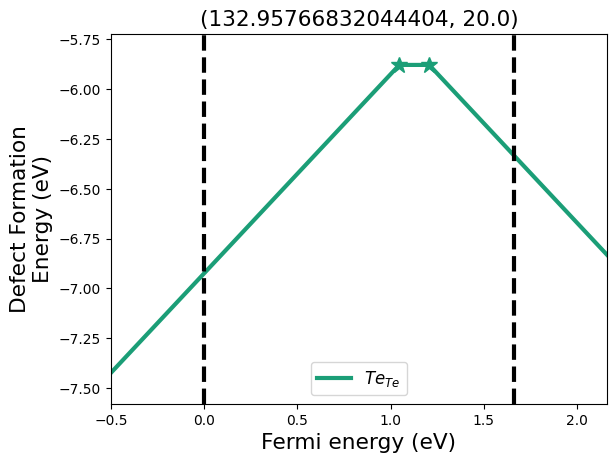


   task_id  charge_state  nsites    Lz  magmom        Ef     vbm  bandgap
0      303            -1      75  25.0     3.0 -4.552923 -1.6075   1.6594
1      313             0      75  25.0     2.0 -5.875067 -1.6075   1.6594
2      361             1      75  25.0     1.0 -6.813778 -1.6075   1.6594
transition levels:{'Sub_Te_on_Te_mult50@0-1-2': {0.938711240000016: [0, 1], 1.3221437100000184: [0, -1]}}


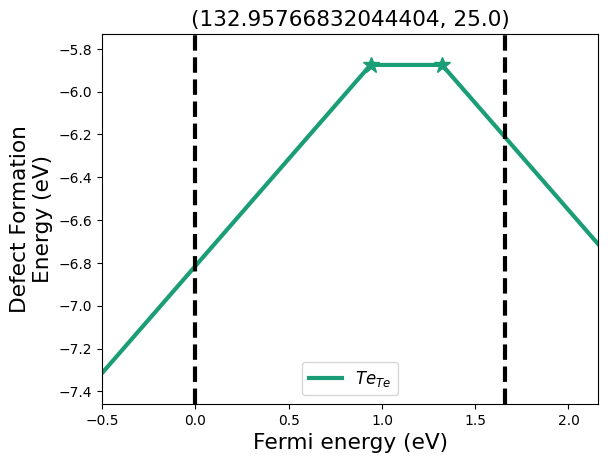


   task_id  charge_state  nsites    Lz  magmom        Ef     vbm  bandgap
0      315            -1     108  25.0     3.0 -4.603017 -1.6087     1.66
1      345             0     108  25.0     2.0 -5.848374 -1.6087     1.66
2      357             1     108  25.0     1.0 -6.865008 -1.6087     1.66
transition levels:{'Sub_Te_on_Te_mult72@0-1-2': {1.0166339500000283: [0, 1], 1.245356509999966: [0, -1]}}


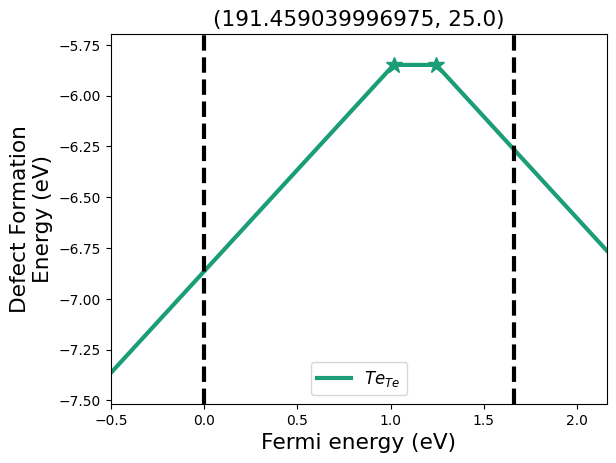


   task_id  charge_state  nsites    Lz  magmom        Ef     vbm  bandgap
1      330            -1     108  20.0     3.0 -4.684573 -0.7782   1.6603
0      328             0     108  20.0     2.0 -5.853075 -0.7782   1.6603
2      352             1     108  20.0     1.0 -6.944698 -0.7782   1.6603
transition levels:{'Sub_Te_on_Te_mult72@0-1-2': {1.0916231500000626: [0, 1], 1.1685012399999855: [0, -1]}}


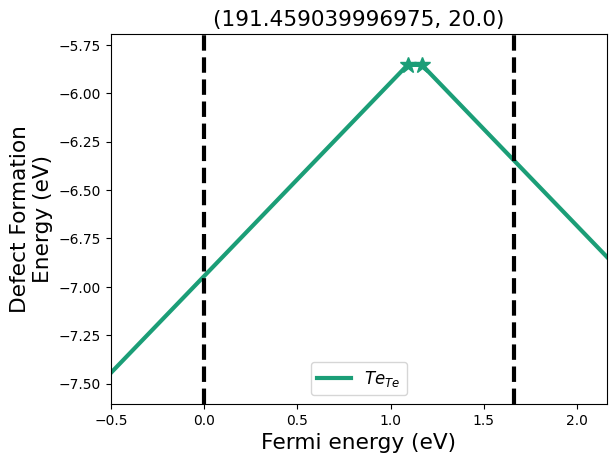


   task_id  charge_state  nsites    Lz  magmom        Ef     vbm  bandgap
2      688            -1      48  20.0     3.0 -4.161903 -0.5668   1.6108
1      683             0      48  20.0     2.0 -5.638044 -0.5668   1.6108
0      606             1      48  20.0     1.0 -6.563512 -0.5668   1.6108
transition levels:{'Sub_Te_on_Te_mult32@0-1-2': {0.9254682600000018: [0, 1], 1.4761407799999795: [0, -1]}}


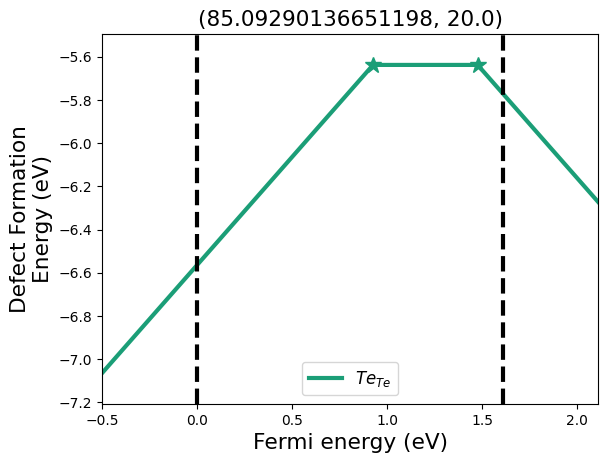


   task_id  charge_state  nsites    Lz  magmom        Ef     vbm  bandgap
2      685            -1      48  25.0     3.0 -3.978088 -1.4561   1.6105
1      680             0      48  25.0     2.0 -5.638092 -1.4561   1.6105
0      676             1      48  25.0     1.0 -6.394344 -1.4561   1.6105
transition levels:{'Sub_Te_on_Te_mult32@0-1-2': {0.7562527300000363: [0, 1], 1.6600032199999726: [-1, 0]}}


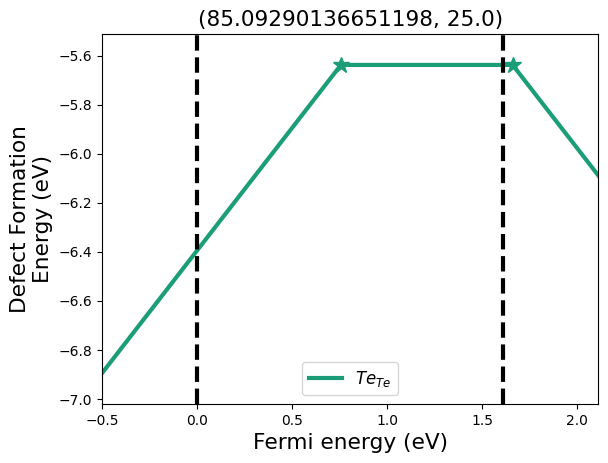


     charge        area  1/sqrt(area)    lz  bandgap  transition energy
9   (-1, 0)   85.092901      0.108406  20.0   1.6108           1.476141
11  (-1, 0)   85.092901      0.108406  25.0   1.6105           1.660003
1   (-1, 0)  132.957668      0.086725  20.0   1.6598           1.207034
3   (-1, 0)  132.957668      0.086725  25.0   1.6594           1.322144
7   (-1, 0)  191.459040      0.072271  20.0   1.6603           1.168501
5   (-1, 0)  191.459040      0.072271  25.0   1.6600           1.245357
8    (0, 1)   85.092901      0.108406  20.0   1.6108           0.925468
10   (0, 1)   85.092901      0.108406  25.0   1.6105           0.756253
0    (0, 1)  132.957668      0.086725  20.0   1.6598           1.046816
2    (0, 1)  132.957668      0.086725  25.0   1.6594           0.938711
6    (0, 1)  191.459040      0.072271  20.0   1.6603           1.091623
4    (0, 1)  191.459040      0.072271  25.0   1.6600           1.016634
right!!
=======================================================

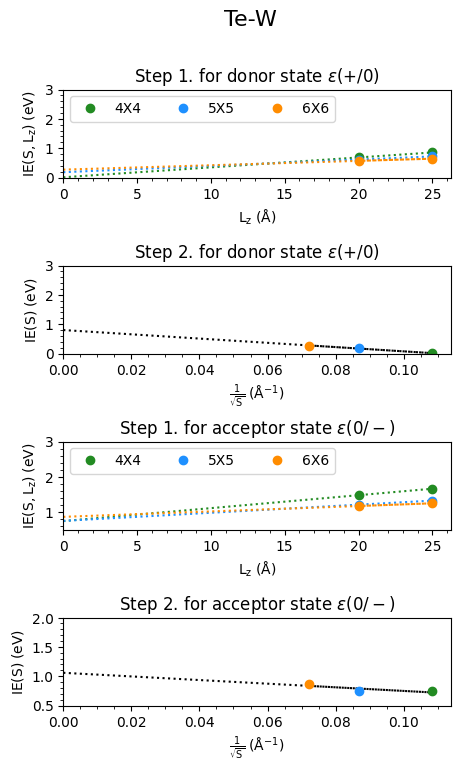

In [298]:
main()

In [307]:
db = get_db("antisiteQubit", "W_Te_Ef_gamma")
es = db.collection.find({"task_id": {"$in": [285, 300, 349]}})
data = []
for e in es:
    st = Structure.from_dict(e["output"]["structure"])
    info = get_st(st)[0]
    info.update({"taskid": e["task_id"], "charge": e["charge_state"]})
    data.append(info)
display(pd.DataFrame(data))

[3.5046, 3.5046, 4.0]
[2.4816 2.4815 2.4815 0.     3.6058]
[3.5046, 3.5046, 4.0]
[2.4831 2.4831 2.4831 0.     3.5412]
[3.5046, 3.5046, 4.0]
[2.5354 2.5354 2.5354 0.     2.9556]


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,taskid,charge
0,2.48155,2.48154,2.48154,3.60576,1.60128,1.60128,1.60128,3.60576,3.5046,3.5046,4.0,285,-1
1,2.48306,2.48305,2.48305,3.54122,1.56176,1.56176,1.56176,3.54122,3.5046,3.5046,4.0,300,0
2,2.53540,2.53540,2.53540,2.95558,1.26122,1.26122,1.26122,2.95558,3.5046,3.5046,4.0,349,1


# Te-based structure in owls/mx2_antisite_basic_aexx0.25_final

In [311]:
db = get_db("owls", "mx2_antisite_basic_aexx0.25_final")
es = db.collection.find({"task_label": "HSE_scf", "chemsys": "Mo-Te"})
data = []
for e in es:
    st = Structure.from_dict(e["output"]["structure"])
    info = get_st(st)[0]
    info.update({"taskid": e["task_id"], "charge": e["charge_state"]})
    data.append(info)
display(pd.DataFrame(data))

[3.5052, 3.5052, 4.0]
[2.5746 2.5746 2.5746 0.     3.0561]
[3.5052, 3.5052, 4.0]
[2.5276 2.5276 2.5276 0.     2.9736]


,d1,d2,d3,d4,z1,z2,z3,z4,a,b,c,taskid,charge
0,2.57458,2.57456,2.57456,3.05614,1.40166,1.40166,1.40166,3.05614,3.5052,3.5052,4.0,3302,0
1,2.52758,2.52757,2.52757,2.97364,1.31218,1.31218,1.31218,2.97364,3.5052,3.5052,4.0,3522,0


# Check output MAMOM related to magnetic JTE

## triplet

In [507]:
db = get_db("single_photon_emitter", "standard_defect")

In [536]:
es = db.collection.find({"task_id": {"$in": [640, 642, 643, 632, 636, 653]}})
triplet_data = []
for e in es:
    NN = e["NN"]
    info = {}
    info["chemsys"] = e["chemsys"]
    info["taskid"] = e["task_id"]
    print(e["chemsys"], sum([e["calcs_reversed"][0]["output"]["outcar"]["magnetization"][nn]["tot"] for nn in range(75)]))
    for nn in NN:
        magmom = e["calcs_reversed"][0]["output"]["outcar"]["magnetization"][nn]["tot"]
        info[nn] = magmom
    info["total_mag"] = e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"]
    info["E"] = e["output"]["energy"]

    triplet_data.append(info)

Mo-Se 1.7160000000000017
Te-W 1.394
S-W 1.5739999999999998
Se-W 1.572999999999998
Mo-S 1.7280000000000002
Mo-Te 1.6059999999999999


In [537]:
triplet_df = pd.DataFrame(triplet_data)
display(triplet_df.loc[triplet_df["chemsys"].str.contains("Te"), ["chemsys", "taskid",54,49,55,74,"total_mag", "E"]].round(2))
display(triplet_df.loc[(triplet_df["chemsys"].str.contains("S")) | 
                       (triplet_df["chemsys"].str.contains("Se")), :"total_mag"].round(2))

,chemsys,taskid,54,49,55,74,total_mag,E
1,Te-W,636,-0.21,-0.14,-0.14,1.22,2.0,-590.89
5,Mo-Te,653,-0.22,-0.43,-0.45,1.84,2.0,-551.91


,chemsys,taskid,5,6,0,25,total_mag
0,Mo-Se,632,-0.32,-0.32,-0.32,2.12,2.0
2,S-W,640,-0.13,-0.13,-0.13,1.64,2.0
3,Se-W,642,-0.16,-0.16,-0.16,1.55,2.0
4,Mo-S,643,-0.26,-0.26,-0.26,2.17,2.0


## singlet

In [539]:
es = db.collection.find({"task_id": {"$in": [690, 702, 715, 699, 700, 721, 847, 848, 849]}})
singlet_data = []
for e in es:
    NN = e["NN"]
    info = {}
    info["chemsys"] = e["chemsys"]
    info["taskid"] = e["task_id"]
    print(e["chemsys"], sum([e["calcs_reversed"][0]["output"]["outcar"]["magnetization"][nn]["tot"] for nn in range(75)]))
    for nn in NN:
        magmom = e["calcs_reversed"][0]["output"]["outcar"]["magnetization"][nn]["tot"]
        info[nn] = magmom
    info["total_mag"] = e["calcs_reversed"][0]["output"]["outcar"]["total_magnetization"]
    info["E"] = e["output"]["energy"]

    singlet_data.append(info)

Se-W -0.0019999999999999983
S-W -2.6020852139652106e-18
Mo-S -0.002000000000000001
Mo-Se -0.0009999999999999966
Te-W 0.0
Mo-Te 0.16100000000000014
Te-W 1.413
Mo-Te 1.585
Mo-Te -0.16300000000000003


In [540]:
singlet_df = pd.DataFrame(singlet_data)
display(
    singlet_df.loc[singlet_df["chemsys"].str.contains("Te"), ["chemsys", "taskid",54,49,55,74,"total_mag", "E"]].round(2))
display(singlet_df.loc[(singlet_df["chemsys"].str.contains("S")) | 
                       (singlet_df["chemsys"].str.contains("Se")), :"total_mag"].round(2))


,chemsys,taskid,54,49,55,74,total_mag,E
4,Te-W,715,-0.00,-0.00,-0.00,0.00,0.0,-590.59
5,Mo-Te,721,0.20,-0.12,-0.11,-0.35,0.0,-551.64
6,Te-W,847,-0.21,-0.14,-0.22,0.97,2.0,-590.63
7,Mo-Te,848,-0.39,-0.44,-0.23,1.68,2.0,-551.88
8,Mo-Te,849,0.12,0.12,-0.19,0.35,-0.0,-551.64


,chemsys,taskid,5,6,0,25,total_mag
0,Se-W,690,0.02,-0.07,0.04,0.0,0.0
1,S-W,699,0.02,-0.04,0.02,0.0,-0.0
2,Mo-S,700,0.00,-0.04,0.03,0.0,0.0
3,Mo-Se,702,0.03,0.04,-0.06,0.0,-0.0
